# Bone segmentation 

Imports and helping functions

In [1]:
from skimage.io import imread
import matplotlib.pyplot as plt
import maxflow
import numpy as np

def segmentation_histogram(ax, I, S, edges=None):
    '''
    Histogram for data and each segmentation label.
    '''
    if edges is None:
        edges = np.linspace(I.min(), I.max(), 100)
    ax.hist(I.ravel(), bins=edges, color = 'k')
    centers = 0.5 * (edges[:-1] + edges[1:])
    for k in range(S.max() + 1):
        ax.plot(centers, np.histogram(I[S==k].ravel(), edges)[0])


Inspect the data. 

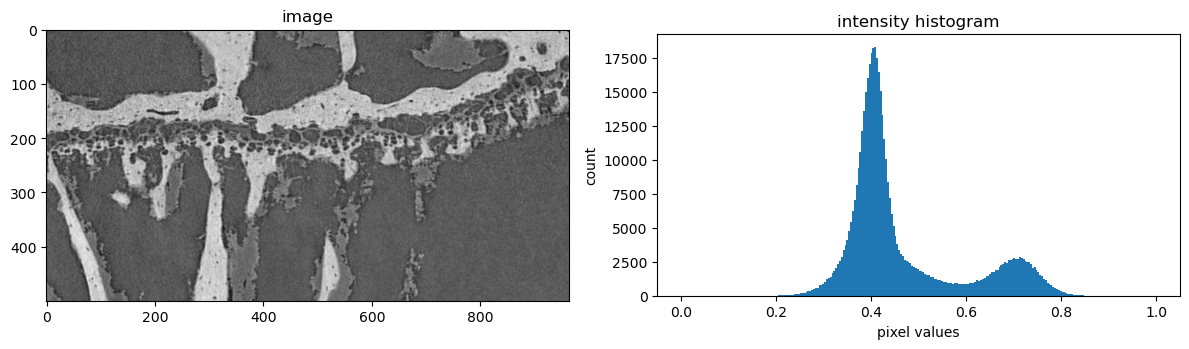

In [2]:
I = imread('../week5/data/V12_10X_x502.png').astype(float)/(2**16-1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(I, cmap=plt.cm.gray)
ax[0].set_title('image')

edges = np.linspace(0, 1, 257)
ax[1].hist(I.ravel(), edges)
ax[1].set_xlabel('pixel values')
ax[1].set_ylabel('count')
ax[1].set_title('intensity histogram')
ax[1].set_aspect(0.5/ax[1].get_data_ratio())
plt.tight_layout()
plt.show()

Define the likelihood and check the max-likelihood solution (thresholding).

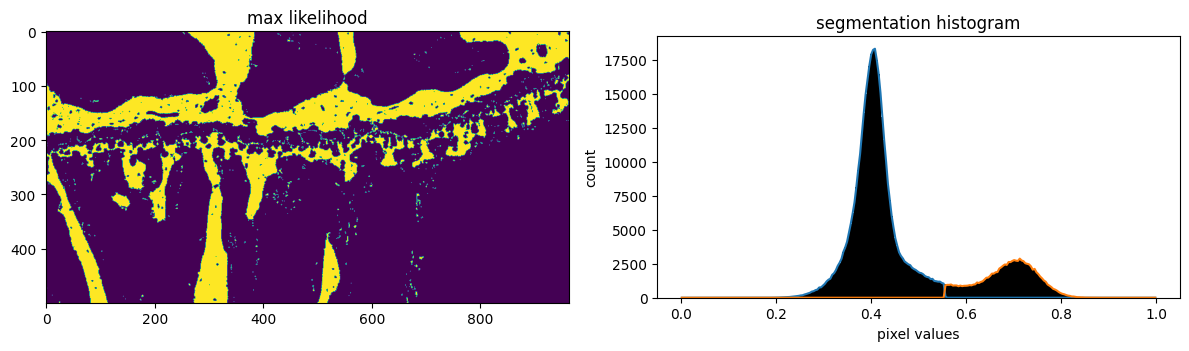

In [16]:
#%% Define likelihood
mu = [0.40, 0.71]

# A "cost" array is calculated, where each pixel's deviation from the two mean values is squared. 
# This results in a 3D array where the third dimension has two layers, 
# each representing the squared difference of the pixel intensities from one of the two means.
U = np.stack([(I-mu[i])**2 for i in range(len(mu))], axis=2)

#  The initial segmentation is determined by finding which mean value (0 or 1) each pixel is closer to in terms of squared difference. 
# This results in a 2D array where each pixel is labeled as belonging to the segment 0 or 1 based on which mean it's closer to.
S0 = np.argmin(U, axis=2)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(S0)
ax[0].set_title('max likelihood')

segmentation_histogram(ax[1], I, S0, edges=edges)
ax[1].set_aspect(0.5/ax[1].get_data_ratio())
ax[1].set_xlabel('pixel values')
ax[1].set_ylabel('count')
ax[1].set_title('segmentation histogram')
plt.tight_layout()
plt.show()

Define MRF and use graph cuts to get the solution with the smallest posterior energy.

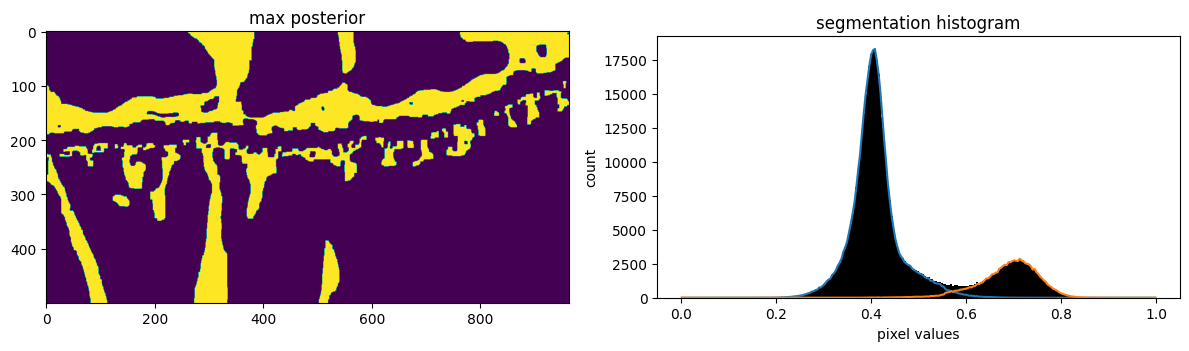

In [17]:
#%% Define prior, construct graph, solve
beta  = 0.1
g = maxflow.Graph[float]() # Create a graph with integer capacities.
nodeids = g.add_grid_nodes(I.shape) # Adds a node for each pixel.
g.add_grid_edges(nodeids, beta) # Adds edges between 4-neighbors of each pixel.
g.add_grid_tedges(nodeids, U[...,1], U[...,0]) # Adds terminal edges. 
    # The second argument is the capacity of the edge from the node to the sink, 
    # and the third argument is the capacity of the edge from the node to the source.

#  solving
g.maxflow()
S = g.get_grid_segments(nodeids)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(S)
ax[0].set_title('max posterior')

segmentation_histogram(ax[1], I, S, edges=edges)
ax[1].set_aspect(0.5/ax[1].get_data_ratio())
ax[1].set_xlabel('pixel values')
ax[1].set_ylabel('count')
ax[1].set_title('segmentation histogram')
plt.tight_layout()
plt.show()

## Optional: three classes

Use alpha expansion from maxflow to obtain three-class segmentation.

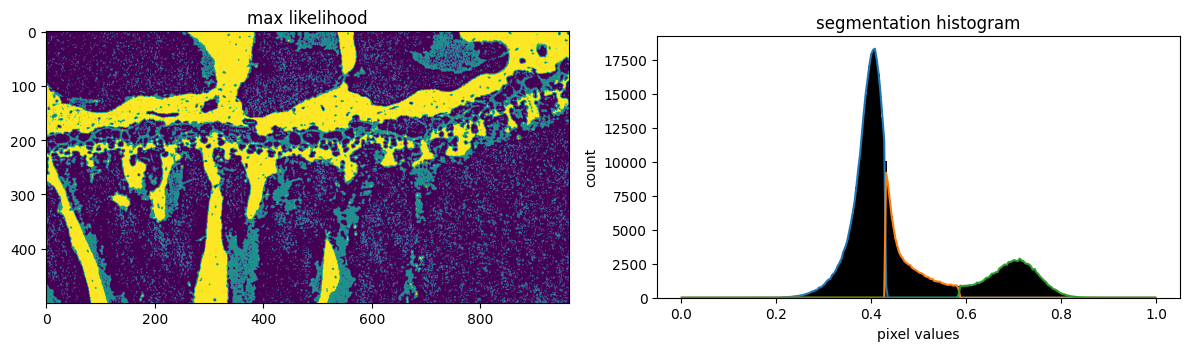

In [18]:
#%% Define likelihood
mu = [0.40, 0.46, 0.71]
U = np.stack([(I-mu[i])**2 for i in range(len(mu))], axis=2)
S0 = np.argmin(U, axis=2)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(S0)
ax[0].set_title('max likelihood')

segmentation_histogram(ax[1], I, S0, edges=edges)
ax[1].set_aspect(0.5/ax[1].get_data_ratio())
ax[1].set_xlabel('pixel values')
ax[1].set_ylabel('count')
ax[1].set_title('segmentation histogram')
plt.tight_layout()
plt.show()

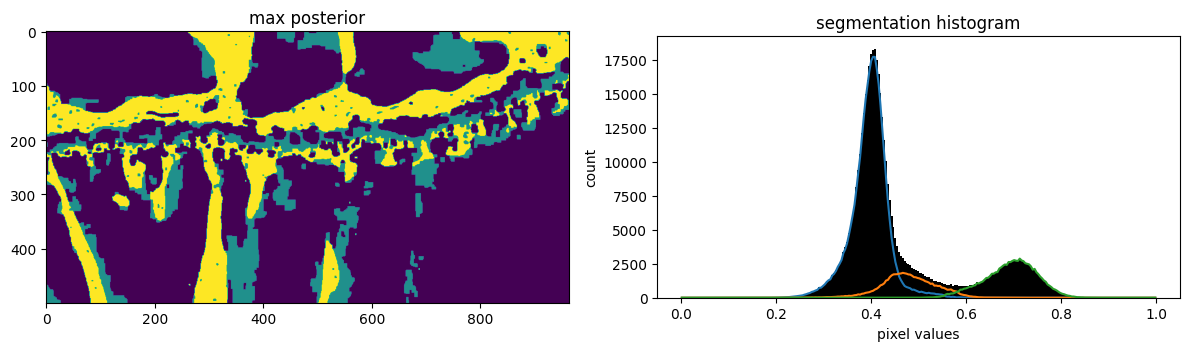

In [19]:
#%% Define prior and solve
beta  = 0.02
B = beta - beta * np.eye(len(mu))
#  solving
S = S0.copy()
maxflow.fastmin.aexpansion_grid(U, B, labels = S)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(S)
ax[0].set_title('max posterior')

segmentation_histogram(ax[1], I, S, edges=edges)
ax[1].set_aspect(0.5/ax[1].get_data_ratio())
ax[1].set_xlabel('pixel values')
ax[1].set_ylabel('count')
ax[1].set_title('segmentation histogram')
plt.tight_layout()
plt.show()